# Alanine dipeptide pyCHARMM example


## Build an alanine-dipeptide molecule minimize, visualize
## Solvate in a box of water using MMTSB Toolset

### Note that this notebook requires that you have the MMTSB Toolset available, that you start "pymol -R &" at the terminal window before you start the jupyter lab, and that the environment variable CHARMM_LIB_DIR are defined. (Note: CHARMM_LIB_DIR should point to <charmm_install_path>/lib)

# pyCHARMM header files plus some of the necessary functionality

In [1]:
# This script provides a simple example of building an
# alanine dipeptide and minimizing the structure and then
# calculating the energy to illustrate functionality to be
# exposed in pyCHARMM.
#  copyright C.L. Brooks III, June 1, 2022

# These are general python modules needed for this  tutorial
import os
import sys

# These are a subset of the pycharmm modules that were installed when
# pycharmm was installed in your python environment
import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm


##  First read in the topology and parameter files
### The topology file contains the information pertinent to building molecular systems, either as independent molecules or as "residues" linked together to form more complex structures, i.e., proteins and nucleic acids. The parameter file contains the parameters that provide the information for the force field based calculations. CHARMM has topology and parameter files that are non-overlapping representations of different "regions" of chemical space, e.g., proteins ("_prot"), nucleic acids ("_na"), ethers, lipids, small drug-like molecules ("_cgenff"), etc. Here we will utilize the protein, water and ion topology and parameter files. These files are required to "generate" (see below) a psf that is necessary preceeding any molecular mechanics calculation.

In [2]:
# Read in the topology (rtf) and parameter file (prm) for proteins
# equivalent to the CHARMM scripting command: read rtf card name toppar/top_all36_prot.rtf
read.rtf('../toppar/top_all36_prot.rtf')
# equivalent to the CHARMM scripting command: read param card flexible name toppar/par_all36m_prot.prm
read.prm('../toppar/par_all36m_prot.prm', flex=True)

# stream in the water/ions parameter using the pycharmm.lingo module
# equivalent to the CHARMM scripting command: stream toppar/toppar_water_ions.str
pycharmm.lingo.charmm_script('stream ../toppar/toppar_water_ions.str')
# end toppar/toppar_water_ions.str


  
 CHARMM>     read rtf card -
 CHARMM>     name ../toppar/top_all36_prot.rtf
 VOPEN> Attempting to open::../TOPPAR/TOP_ALL36_PROT.RTF::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *>>>>>>>>CHARMM36 ALL-HYDROGEN TOPOLOGY FILE FOR PROTEINS <<<<<<
 TITLE> *>>>>> INCLUDES PHI, PSI CROSS TERM MAP (CMAP) CORRECTION <<<<<<<
 TITLE> *>>>>>>>>>>>>>>>>>>>>>>>>>> MAY 2011 <<<<<<<<<<<<<<<<<<<<<<<<<<<<
 TITLE> * ALL COMMENTS TO THE CHARMM WEB SITE: WWW.CHARMM.ORG
 TITLE> *             PARAMETER SET DISCUSSION FORUM
 TITLE> *
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name ../toppar/par_all36m_prot.prm -
 CHARMM>     flex
 VOPEN> Attempting to open::../TOPPAR/PAR_ALL36M_PROT.PRM::

          PARAMETER FILE BEING READ FROM UNIT 91
 TITLE> *>>>> CHARMM36 ALL-HYDROGEN PARAMETER FILE FOR PROTEINS <<<<<<<<<<
 TITLE> *>>>>> INCLUDES PHI, PSI CROSS TERM MAP (CMAP) CORRECTION <<<<<<<<
 TITLE> *>>>>>>>>>>>>>>>>>>>>>>

1

BOND lists and IMAGE atoms cleared.
  
 CHARMM>    BOMLEV @bom @PARA
 Parameter: BOM -> "0"
 Parameter: PARA -> "" <empty>
  
 CHARMM>    WRNLEV @wrn @PARA
 Parameter: WRN -> "5"
 Parameter: PARA -> "" <empty>
  
 CHARMM>     
  
 CHARMM>    return
 VCLOSE: Closing unit   99 with status "KEEP"

                    RETURNING TO INPUT STREAM    90
  


## Specify the sequence of residues, generate them and build them.
### To do this we need to input the seqnece of "residues" we wish to do calculations on, generate the particlar sequence with any blocking groups needed, here we will terminate the alanine peptide with an acetyl N-terminal "patch" and an N-methyl amide C-terminal "patch". Note we will call this "segment" of structure ADP and during the generation of the psf data structures in CHARMM we will setup the ic (internal coordinate) tables that will allow us to build the structure from the known bond distances, angles and dihedrals after seeding the building by specifying two atoms along a line and the third to define the plane of the molecule.

In [3]:
# read in the sequence of the protein to be generated
# only useful for the same residue
# equivalent to the CHARMM scripting command:
# read sequence 1
# ala
read.sequence_string('ALA')

# equivalent to the CHARMM scripting command: generate ADP first ACE last CT3 setup
gen.new_segment(seg_name='ADP', first_patch='ACE', last_patch='CT3', setup_ic=True)

# equivalent to the CHARMM scripting command: ic param
ic.prm_fill(replace_all=False)
# equivalent to the CHARMM scripting command: ic seed 1 CAY 1 CY 1 N
ic.seed(res1=1, atom1='CAY', res2=1, atom2='CY', res3=1, atom3='N')
# equivalent to the CHARMM scripting command: ic build
ic.build()

# The coor orie command is useful to expose since it allows one to
# orient the system in preparation for other calculations
# equivalent to the CHARMM scripting command: coor orient
coor.orient(by_rms=False,by_mass=False,by_noro=False)
# equivalent to the CHARMM scripting command: print coor
coor.show()
# If pdb directory doesn't alrady exist make it here.
if not os.path.isdir('pdb'): os.system('mkdir pdb')
# equivalent to the CHARMM scripting command: write coor pdb name pdb/initial.pdb
write.coor_pdb('pdb/initial.pdb')


          RESIDUE SEQUENCE --     1 RESIDUES
          ALA 
 THE PATCH 'ACE' WILL BE USED FOR THE FIRST RESIDUE
 THE PATCH 'CT3' WILL BE USED FOR THE LAST  RESIDUE
 AUTGEN: Autogenerating specified angles and dihedrals.
 GENPSF> Segment   1 has been generated. Its identifier is ADP.
 PSFSUM> PSF modified: NONBOND lists and IMAGE atoms cleared.
 PSFSUM> Summary of the structure file counters :
         Number of segments      =        1   Number of residues   =        1
         Number of atoms         =       22   Number of groups     =        6
         Number of bonds         =       21   Number of angles     =       36
         Number of dihedrals     =       41   Number of impropers  =        4
         Number of cross-terms   =        0   Number of autogens   =        0
         Number of HB acceptors  =        2   Number of HB donors  =        2
         Number of NB exclusions =        0   Total charge =    0.00000
  
 CHARMM>     coor orient

 ORIENT THE COORDINATES TO ALIGN W

## This little trick let's us view the structure with pymol provided we started pymol before using pymol -R &
### Open a terminal window in jupyter-lab and run $ pymol -R & before running the cell that follows.
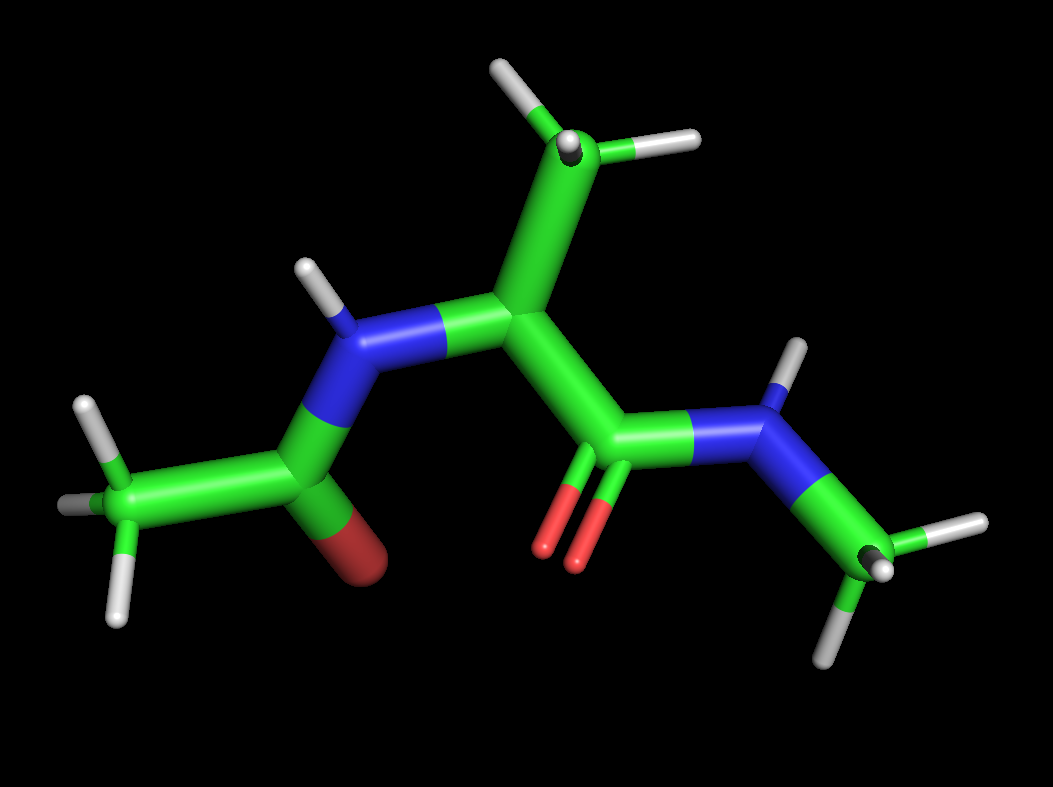

In [15]:
# if you can run pymol in your setup issue the command above in the terminal and set the usepymol logical
# here:
usepymol = False
if usepymol:
    import xmlrpc.client as xmlrpclib
    cmd = xmlrpclib.ServerProxy('http://localhost:9123')
    cmd.reinitialize()
# Otherwise set usepymol to False and proceed.

In [16]:
# This import enables pymol command interpreter to be used
if usepymol:
    # We can use this command interface to alter the view/representation and selection
    cmd.load('pdb/initial.pdb')

## Now lets minimize the structure and view the minimized structure in pymol
### To do this we will first specify the non-bonded parameters we want to use for these molecular mechanics calculations. Note we are spcifying that we will use the fswitch and vfswitch force-switching functions to truncate the electrostatic and vdW interactions. The switching will occur between ctonnb and ctofnb. We will build a non-bonded list to process pairs of interacting atoms using a cutoff radius of cutnb. We will use atom-based electrostatic (atom) and vdW (vatom) non-bonded list generaton schemes and will repreent the Coulomb electrostatic interactions with a constant dielectric constant (versus an r-dependent dielectric constant) of 1 (cdie=1.0). There are multiple ways of inputting the nonbonded parameters, here we create a python object my_nbonds which has a .run() attribute. 
### Next we will use CHARMM's abnr mminimizer to minimize the structure we just build using the non-bonded methods we just specified. The minimizer is set-up to run 1000 steps of minimization unless the energy change falls below 0.001 or the gradient of the energy falls below 0.001, in which case minimization will stop. Finally we print out the final energy.

In [6]:
# Specify nonbonded python object called my_nbonds - this just sets it up
# equivalant CHARMM scripting command: nbonds cutnb 18 ctonnb 13 ctofnb 17 cdie eps 1 atom vatom fswitch vfswitch
my_nbonds = pycharmm.NonBondedScript(
    cutnb=18.0, ctonnb=13.0, ctofnb=17.0,
    eps=1.0,
    cdie=True,
    atom=True, vatom=True,
    fswitch=True, vfswitch=True)

# Implement these non-bonded parameters by "running" them.
my_nbonds.run()

# equivalent CHARMM scripting command: minimize abnr nstep 1000 tole 1e-3 tolgr 1e-3
minimize.run_abnr(nstep=1000, tolenr=1e-3, tolgrd=1e-3)
# equivalent CHARMM scripting command: energy
energy.show()

  
 CHARMM>     nbonds cutnb 18.0 -
 CHARMM>     ctonnb 13.0 -
 CHARMM>     ctofnb 17.0 -
 CHARMM>     eps 1.0 -
 CHARMM>     cdie -
 CHARMM>     atom -
 CHARMM>     vatom -
 CHARMM>     fswitch -
 CHARMM>     vfswitch

 NONBOND OPTION FLAGS: 
     ELEC     VDW      ATOMs    CDIElec  FSWItch  VATOm    VFSWIt  
     BYGRoup  NOEXtnd  NOEWald 
 CUTNB  = 18.000 CTEXNB =999.000 CTONNB = 13.000 CTOFNB = 17.000
 CGONNB =  0.000 CGOFNB = 10.000
 WMIN   =  1.500 WRNMXD =  0.500 E14FAC =  1.000 EPS    =  1.000
 NBXMOD =      5
 There are        0 atom  pairs and        0 atom  exclusions.
 There are        0 group pairs and        0 group exclusions.
 <MAKINB> with mode   5 found     57 exclusions and     41 interactions(1-4)
 <MAKGRP> found     11 group exclusions.
 Generating nonbond list with Exclusion mode = 5
 == PRIMARY == SPACE FOR      221 ATOM PAIRS AND        0 GROUP PAIRS

 General atom nonbond list generation found:
      174 ATOM PAIRS WERE FOUND FOR ATOM LIST
        0 GROUP PAIRS

## Sideline: We can grab the current coordinates from CHARMM, manipulate them and put them back into CHARMM if we wish. pyCHARMM provides the coor.get_positions() and coor.set_positions() commands to enable this. See the manipulations below (which only add 0 to the coordinates) and then give them back to CHARMM

In [7]:
# equivalent CHARMM scripting command: coor show
coor.show()
# equivalent CHARMM scripting command: coor stat
# current is a python dictionary containing the output from coor stat
current = coor.stat()
print('==================> xave {:.2f} yave {:.2f} zave {:.2f}'.format(current['xave'],current['yave'],current['zave']))
print(current)
# xyz will be a pandas dataframe
xyz = coor.get_positions()
print(xyz.info)
xyz += 1
coor.set_positions(xyz)
displaced = coor.stat()
print('==================> xave {:.2f} yave {:.2f} zave {:.2f}'.format(displaced['xave'],displaced['yave'],displaced['zave']))
print(displaced)
# xyz will be a pandas dataframe
xyz = coor.get_positions()
xyz += -1
coor.set_positions(xyz)
returned = coor.stat()
print('==================> xave {:.2f} yave {:.2f} zave {:.2f}'.format(returned['xave'],returned['yave'],returned['zave']))
# Save the minimizaed coordinates
write.coor_pdb('pdb/minimized.pdb')


          COORDINATE FILE MODULE
 TITLE>  * EXECUTING CHARMM SCRIPT FROM PYTHON
 TITLE>  *
   22
    1    1 ALA  CAY   -3.49646  -0.67956  -0.04366 ADP  1      0.00000
    2    1 ALA  HY1   -3.93632   0.15888   0.53781 ADP  1      0.00000
    3    1 ALA  HY2   -3.33665  -1.55170   0.62493 ADP  1      0.00000
    4    1 ALA  HY3   -4.20424  -0.97238  -0.85008 ADP  1      0.00000
    5    1 ALA  CY    -2.21467  -0.26361  -0.65115 ADP  1      0.00000
    6    1 ALA  OY    -2.02830  -0.35753  -1.85981 ADP  1      0.00000
    7    1 ALA  N     -1.28760   0.21564   0.18579 ADP  1      0.00000
    8    1 ALA  HN    -1.44998   0.22754   1.16893 ADP  1      0.00000
    9    1 ALA  CA     0.02744   0.63235  -0.24198 ADP  1      0.00000
   10    1 ALA  HA     0.12212   0.53109  -1.31618 ADP  1      0.00000
   11    1 ALA  CB     0.27826   2.10489   0.14859 ADP  1      0.00000
   12    1 ALA  HB1   -0.49794   2.74994  -0.31868 ADP  1      0.00000
   13    1 ALA  HB2    0.22628   2.23694   1.25179

## The minimized and initial built molecules should appear in the pymol window when you run the cell below
## Compare the two structures, are they different?
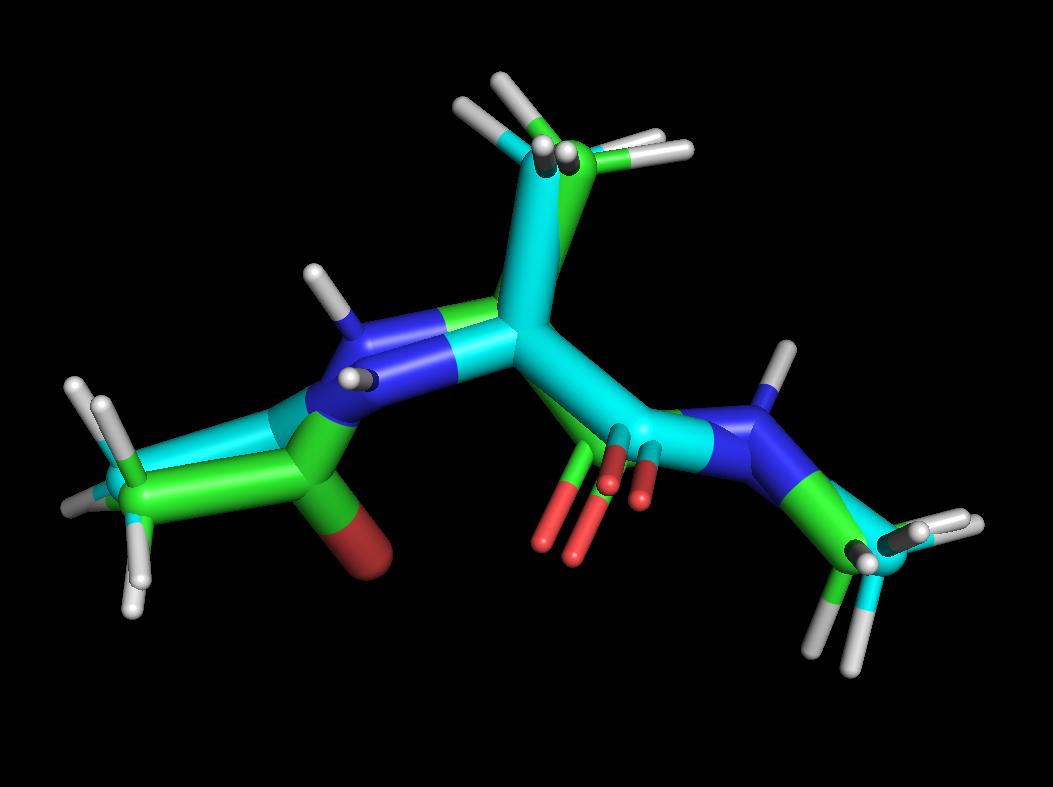

In [17]:
# Now view the minimized coordinates in pymol
if usepymol: 
    cmd.load('pdb/minimized.pdb')

## The code below just illustrates some of the variables one can access from psf and parameters as well as some of the selection syntax you can use.

In [9]:
# Explore some of the pyCHARMM selection syntax
my_atoms = pycharmm.SelectAtoms(seg_id='ADP')
# my_atoms is a pyCHARMM object, but can be converted to a bool list with the list
# command as shown here.
flags = list(my_atoms)
print('DEBUG: SelectAtoms res_name test')
print(flags)

my_atoms = pycharmm.SelectAtoms(chem_type='HA3')
flags = list(my_atoms)
print('DEBUG: SelectAtoms chem_type test')
print(flags)

# Examine access to some of the CHARMM parameter and psf data

# number of atom type codes in topology/parameter
natc = pycharmm.param.get_natc()
# list of atom type codes from parameter/topology files
atc = pycharmm.param.get_atc()
print('DEBUG: list of atom type codes from top/par files')
for i in range(natc):
    print('ATC {} = {}'.format(i,atc[i]))
print('DEBUG: end atom type codes')

# Get the atom type codes for atoms in the psf
n_atoms = psf.get_natom()
iac = psf.get_iac()
print('DEBUG: begin chem types ' + str(natc))
for i in range(n_atoms):
    print('    ', i, ' : ', atc[iac[i]])
print('DEBUG: end chem types')

# Get the atom IUPAC names from PSF
print('DEBUG: begin atom types')
atypes = psf.get_atype()
for i, atom_type in enumerate(atypes):
    print('    ', i, ' : ', atom_type)
print('DEBUG: end atom types')

# Select only atoms with specific IUPAC
my_atoms = pycharmm.SelectAtoms(atom_type='HA')
flags = list(my_atoms)
print('DEBUG: SelectAtoms atom_type test')
print(flags)

# Same thing but only for residue 1
my_atoms = pycharmm.SelectAtoms().by_res_and_type('ADP', '1', 'HA')
flags = list(my_atoms)
for i, flag in enumerate(flags):
    if flag:
        print('    atom i ', i, ' : ', flag)


DEBUG: SelectAtoms res_name test
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
DEBUG: SelectAtoms chem_type test
[False, True, True, True, False, False, False, False, False, False, False, True, True, True, False, False, False, False, False, True, True, True]
DEBUG: list of atom type codes from top/par files
ATC 0 = H
ATC 1 = HC
ATC 2 = HA
ATC 3 = HP
ATC 4 = HB1
ATC 5 = HB2
ATC 6 = HR1
ATC 7 = HR2
ATC 8 = HR3
ATC 9 = HS
ATC 10 = HE1
ATC 11 = HE2
ATC 12 = HA1
ATC 13 = HA2
ATC 14 = HA3
ATC 15 = C
ATC 16 = CA
ATC 17 = CT
ATC 18 = CT1
ATC 19 = CT2
ATC 20 = CT2A
ATC 21 = CT3
ATC 22 = CPH1
ATC 23 = CPH2
ATC 24 = CPT
ATC 25 = CY
ATC 26 = CP1
ATC 27 = CP2
ATC 28 = CP3
ATC 29 = CC
ATC 30 = CD
ATC 31 = CS
ATC 32 = CE1
ATC 33 = CE2
ATC 34 = CAI
ATC 35 = C3
ATC 36 = N
ATC 37 = NR1
ATC 38 = NR2
ATC 39 = NR3
ATC 40 = NH1
ATC 41 = NH2
ATC 42 = NH3
ATC 43 = NC2
ATC 44 = NY
ATC 45 = NP
ATC 46 = O
ATC 47 = OB
ATC 48 = 

## Now we will save the coordinates and the CHARMM psf file (a file that contains the key information about the conectivity and related properties for the molecule we just built), then delete all of the atoms in our system and start again by reading in the psf and coordinates. This is an alternative if you already have generated a psf and saved coordinates elsewhere.

In [10]:
# write coor pdb name pdb/adp.pdb
write.coor_pdb('pdb/adp.pdb')
# write psf card name pdb/adp.psf
write.psf_card('pdb/adp.psf')

# delete atom select all end
psf.delete_atoms(pycharmm.SelectAtoms().all_atoms())

# read psf card name pdb/adp.psf
read.psf_card('pdb/adp.psf')

# read coor pdb name pdb/adp.pdb resid
adp_pdb_file = 'pdb/adp.pdb'
read.pdb(adp_pdb_file, resid=True)

  
 CHARMM>     write name pdb/adp.pdb -
 CHARMM>     coor pdb
 VOPEN> Attempting to open::pdb/adp.pdb::
 RDTITL>  
 RDTITL> No title read.
  Write CHARMM-pdb format
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     write name pdb/adp.psf -
 CHARMM>     psf card
 VOPEN> Attempting to open::pdb/adp.psf::
 RDTITL>  
 RDTITL> No title read.
 VCLOSE: Closing unit   91 with status "KEEP"
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  

 Message from MAPIC: Atom numbers are changed.

 Message from MAPIC:          1 residues deleted.

 Message from MAPIC:          1 segments deleted.
 DELTIC:        21 bonds deleted
 DELTIC:        36 angles deleted
 DELTIC:        41 dihedrals deleted
 DELTIC:         4 improper dihedrals deleted
 DELTIC:         2 donors deleted
 DELTIC:         2 acceptors deleted
  
 CHARMM>     read psf card -
 CHARMM>     name pdb/adp.psf
 VOPEN> Attempting to open::PDB/ADP.PSF::
 MAINIO> Protein structure file being rea

# Solvate the peptide in TIP3P water
## In the following we will use the MMTSB toolset to solvate the blocked alanine residue in a cubic box of TIP3P water using the convpdb.pl commands noted below.

In [11]:
# CHARMM scripting command: system "convpdb.pl -solvate -cutoff 10 -cubic -out charmm22 pdb/adp.pdb
# | convpdb.pl -segnames adp ala -nsel TIP3 > pdb/wt00.pdb"
solvate_command = 'convpdb.pl -solvate -cutoff 10 -cubic -out charmm22 pdb/adp.pdb | '
solvate_command +='convpdb.pl -segnames -nsel TIP3 > pdb/wt00.pdb'
# run the command as a system subprocess
os.system(solvate_command)

read 648 atoms, 216 residues from /Users/brookscl/MMTSB/mmtsb_git-msu//data/water.pdb
read 22 atoms, 1 residues from -
box size: 28.456091 x 28.456091 x 28.456091


0

## Look at the solvated system, does it look ok? Do you see any non-bonded contacts?
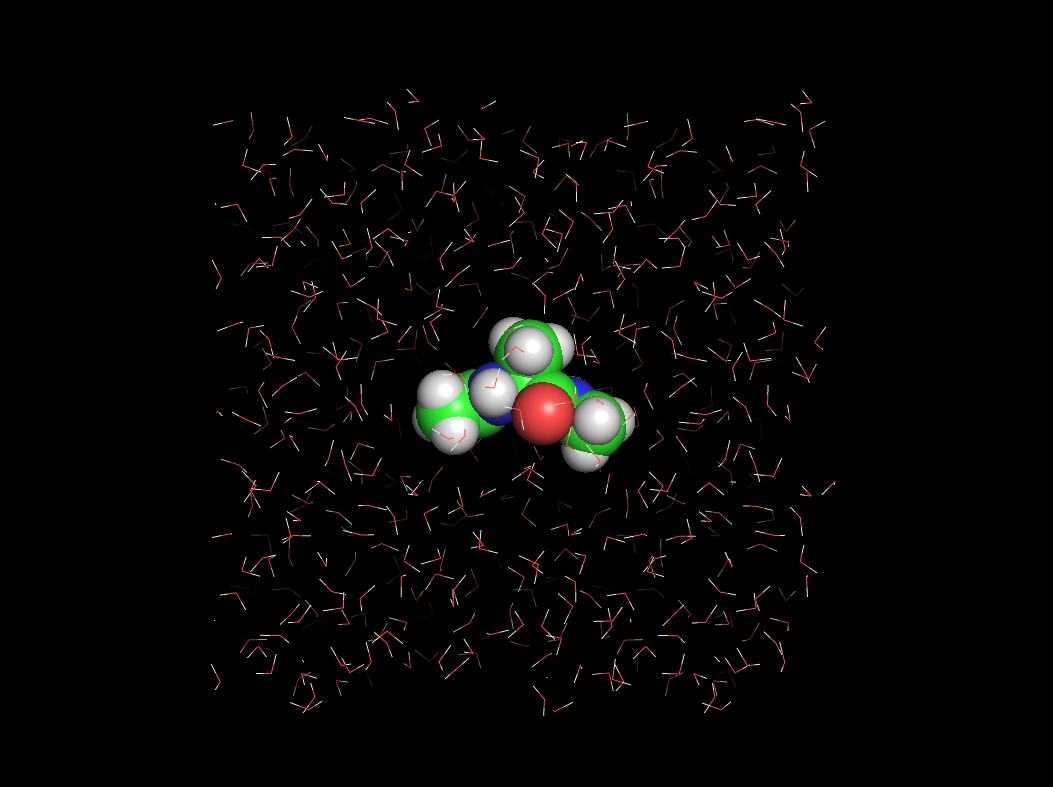
## Let's minimize the structures and see what that looks like.

In [18]:
if usepymol: 
    cmd.reinitialize()
    cmd.load('pdb/adp.pdb')
    cmd.load('pdb/wt00.pdb')
    cmd.show_as('spheres','adp')

## Generate water segment and minimize the system, peptide + solvent, finally save the psf and coordinates
## Note that in "conditioning" the system I first fix the peptide atoms and then minimize the water. I am using the steepest descents algorithm because it works best for large systems and/or when you may have bad contacts.

In [13]:
# Here is an alternative means of reading a sequence
# read sequ pdb name pdb/wt00.pdb
read.sequence_pdb('pdb/wt00.pdb')

# Another example of the generate command
# generate wt00 noangle nodihedral
gen.new_segment('WT00', angle=False, dihedral=False)

# read coor pdb name pdb/adp.pdb resid
read.pdb('pdb/wt00.pdb', resid=True)

# get the coor statistics to construct boxlengths
# coor stat
stats = coor.stat()

# boxsize
xsize = stats['xmax'] - stats['xmin']
ysize = stats['ymax'] - stats['ymin']
zsize = stats['zmax'] - stats['zmin']
boxsize = max(xsize, ysize, zsize)

# half box size
boxhalf = boxsize / 2.0

# CHARMM scripting: crystal define cubic @boxsize @boxsize @boxsize 90 90 90
crystal.define_cubic(boxsize)
# CHARMM scripting: crystal build cutoff @boxhalf noper 0
crystal.build(boxhalf)

# Turn on image centering - bysegment for peptide, by residue for solvent
# CHARMM scripting: image byseg xcen 0 ycen 0 zcen 0 select segid adp end
image.setup_segment(0.0, 0.0, 0.0, 'ADP')
# CHARMM scripting: image byres xcen 0 ycen 0 zcen 0 select resname tip3 end
image.setup_residue(0.0, 0.0, 0.0, 'TIP3')

# Now specify nonbonded cutoffs for solvated box
cutnb = min(boxhalf,12)
cutim = cutnb
ctofnb = cutnb - 1.0
ctonnb = cutnb - 3.0

# Another nbonds example
# CHARMM scripting: nbonds cutnb @cutnb cutim @cutim ctofnb @ctofnb ctonnb @ctonnb -
#        inbfrq -1 imgfrq -1
pycharmm.NonBondedScript(
    cutnb=cutnb, cutim=cutim, ctonnb=ctonnb, ctofnb=ctofnb,
    eps=1.0,
    cdie=True,
    atom=True, vatom=True,
    fswitch=True, vfswitch=True,
    inbfrq=-1, imgfrq=-1).run()

# Fix the peptide and minimize the solvent to "fit"
# CHARMM scripting: cons fix select segid adp end
cons_fix.setup(pycharmm.SelectAtoms(seg_id='ADP'))

# Minimize the solvent positions with periodic boundary conditions using steepest descents
# CHARMM scripting: mini sd nstep 200 tole 1e-3 tolgrd 1e-3
minimize.run_sd(nstep=200, tolenr=1e-3, tolgrd=1e-3)

# Turn off fixed atoms
# CHARMM scripting: cons fix select none end
cons_fix.turn_off()

# Write the psf and coordinates for the solvated peptide
# write psf card name pdb/adp+wat.psf
write.psf_card('pdb/adp+wat.psf')
# write coor pdb name pdb/adp+wat_min.pdb
write.coor_pdb('pdb/adp+wat_min.pdb')

  
 CHARMM>     read sequence pdb -
 CHARMM>     name pdb/wt00.pdb
 VOPEN> Attempting to open::PDB/WT00.PDB::
 MAINIO> Sequence information being read from unit  91.
 TITLE>  *

          RESIDUE SEQUENCE --   700 RESIDUES
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3
          TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP3TIP

MINI>       10  -6441.34096    791.05335      8.48296      0.00896
MINI INTERN>       29.83533     66.93719      0.00000      0.00000      0.00000
MINI EXTERN>      563.32624  -6876.55356      0.00000      0.00000      0.00000
MINI IMAGES>      -52.53754   -172.34862      0.00000      0.00000      0.00000
 ----------       ---------    ---------    ---------    ---------    ---------
MINI>       20  -6820.53156    379.19060      2.38907      0.00401
MINI INTERN>      262.47764    161.13829      0.00000      0.00000      0.00000
MINI EXTERN>      573.41476  -7562.75331      0.00000      0.00000      0.00000
MINI IMAGES>      -53.64478   -201.16417      0.00000      0.00000      0.00000
 ----------       ---------    ---------    ---------    ---------    ---------
MINI>       30  -6955.80993    135.27837      4.14431      0.00431
MINI INTERN>      346.09714    182.41124      0.00000      0.00000      0.00000
MINI EXTERN>      592.00956  -7807.24357      0.00000      0.00000      0.00000

MINI>      160  -7579.29496     28.12767      0.57698      0.00080
MINI INTERN>      224.34179    161.61393      0.00000      0.00000      0.00000
MINI EXTERN>      779.97639  -8400.57181      0.00000      0.00000      0.00000
MINI IMAGES>      -49.63915   -295.01611      0.00000      0.00000      0.00000
 ----------       ---------    ---------    ---------    ---------    ---------
MINI>      170  -7602.45231     23.15734      0.60362      0.00086
MINI INTERN>      223.08165    161.82715      0.00000      0.00000      0.00000
MINI EXTERN>      789.73704  -8428.08048      0.00000      0.00000      0.00000
MINI IMAGES>      -49.15840   -299.85926      0.00000      0.00000      0.00000
 ----------       ---------    ---------    ---------    ---------    ---------
MINI>      180  -7623.89642     21.44411      0.68541      0.00092
MINI INTERN>      219.16270    161.27095      0.00000      0.00000      0.00000
MINI EXTERN>      798.52825  -8449.79365      0.00000      0.00000      0.00000

## Finally, let's visualize the system and see what things look like!
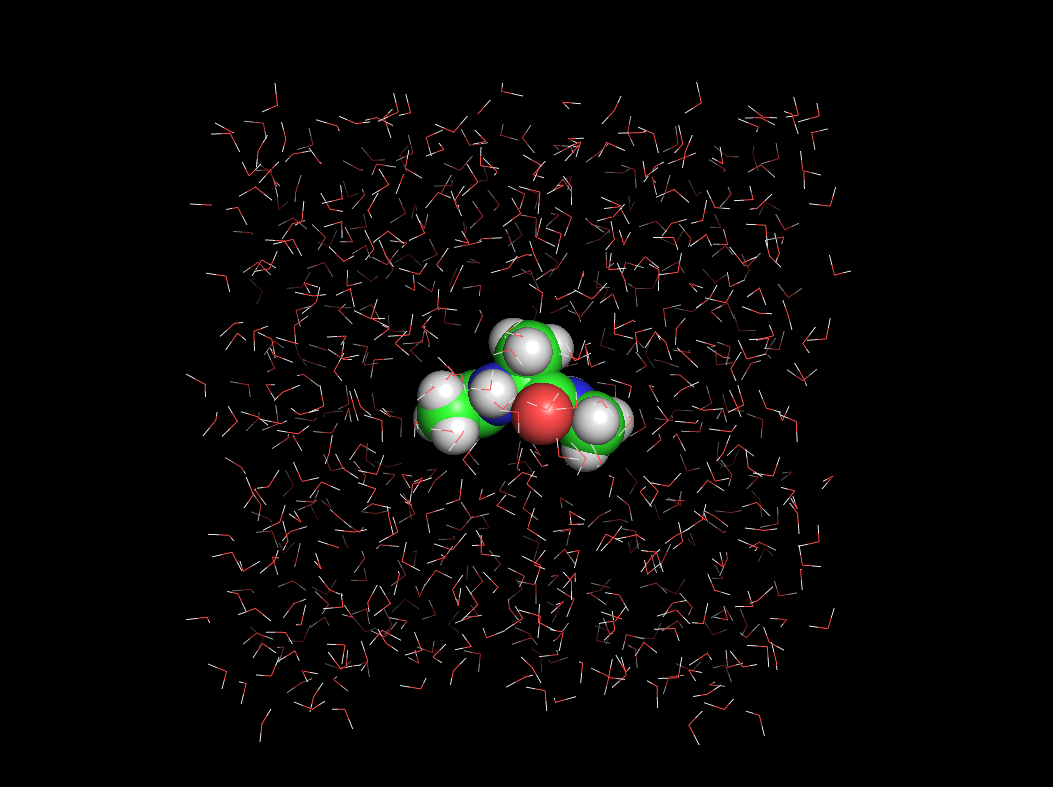

In [14]:
if usepymol:
    cmd.reinitialize()
    cmd.load('pdb/adp+wat_min.pdb')
    cmd.show_as('spheres','resn ALA')

# This is the end of this tutorial example. 
## You should have learned how to 1) build a peptide using the ic (internal coordinate) commands in CHARMM to construct initial coordinates for the system; 2) to minimize the system and examine the results of the minimization; 3) to use the MMTSB Toolset to solvate the system (with convpdb.pl); 4) to prepare the solvated system for further calculations by "conditioning" the solvent after the solvent overlay.
## As an exercise, try modifying this tutorial to build the tri-peptide of sequence A-D-A. Use the same blocking groups, call the sequence TRIP (for tri-peptide).